In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

In [16]:
# .py code help to run the code in screen mode .ipynb cannot do that
# This code can be used to load light curve training dataset and do the
# preprocessing like vertical scaling and extending the light curve
# CNN Model is defined
# Training, learning rate scheduler and early stopping feature included

## -- IMP: Check whether the file name to save the model is complete ##

# Import TF and check for GPU

import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

# Import required libraries

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import save_model, load_model
import math
from sklearn.model_selection import train_test_split
import sys
from numpy import array,append,arange,zeros,exp,sin,random,std
from scipy.interpolate import interp1d

import time


[]
TensorFlow version: 2.15.0


In [17]:
model_load = load_model("/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/ml_model/april24_2024_model_unfDist_LDC_size_horz_scale.h5")
# model_load = load_model("/content/drive/MyDrive/5_AstroFYP_data/april_9_model/april9_2024_model_unfDist_LDC_size_horz_scale.h5")


# Load multiple light curves together

In [18]:
# Load 8bit different size light curve
# 1. Load Lightcurve Dataset
# lc_dir = '/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/test_shape_2/test_lc_shape_2_multisize_multiLDC_1.npy' # 'lc_1_21Feb2024_circles_38_38_px.npy'
lc_dir ='/content/drive/MyDrive/5_AstroFYP_data/april_9_model_training/test_lc_shape_1_multisize_multiLDC_2_details/test_lc_shape_1_multisize_multiLDC_2.npy'
test_lc = np.load(lc_dir)
print("test_lc.shape =", test_lc.shape)
# Vertical scaling

# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))


test_lc.shape = (250, 100)


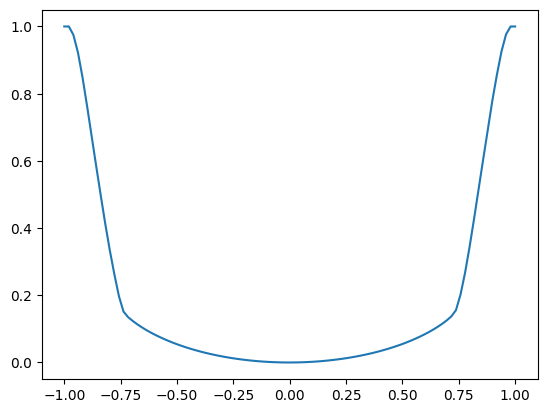

In [19]:
# plt.plot(np.linspace(-1,1,len(test_lc[0])), test_lc[0])
plt.plot(np.linspace(-1,1,len(test_lc_scaled[0])), test_lc_scaled[0])
plt.show()

In [20]:
# Append with ones (if required only.
# eg APPENING not required for BATMAN lightcurve since we already append BATMAN
# while saving it as csv file and npy file)
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],150))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,25:125] = test_lc_scaled[i] # For input size of 100
    # test_lc_scaled_append[i,35:135] = test_lc_scaled[i] # For input size of 120
print("Extended the light curves")

Extended the light curves


In [21]:
# 5. Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros

    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        # print("left_index =", left_index)
        # print("right_index =", right_index)
        # print("Length =", right_index-left_index+1)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='linear')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)

        # # Replacing end elements with 1

        # y_interpolated[0:9] = np.ones(len(y_interpolated[0:9]))
        # # print(f"len(y_interpolated[0:9])) = {len(y_interpolated[0:9])}")

        # y_interpolated[111:120] = np.ones(len(y_interpolated[111:120]))
        # # print(f"len(y_interpolated[111:120])) = {len(y_interpolated[111:120])}")

        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
# del test_lc_scaled_append

processed_test_lc = test_lc_horiz_scaled
# del test_lc_horiz_scaled


Length of one LC =  150
input_lc_dataset_interpol.shape = (250, 120)
center_index = 75


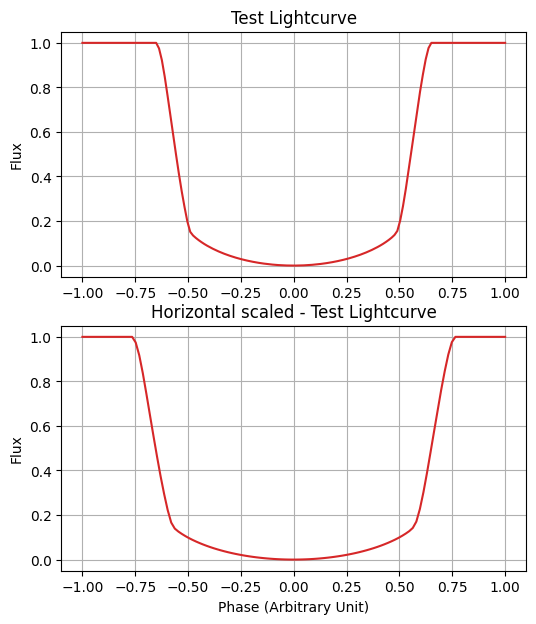

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(6, 7))  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title('Test Lightcurve')
ph = np.linspace(-1,1,len(test_lc_scaled_append[0]))
axes[0].plot(ph, test_lc_scaled_append[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
# axes[0].set_xlabel('Phase (Arbitrary Unit)')
# axes[0].set_xlim(-0.25, 0.25)



ph = np.linspace(-1,1,len(processed_test_lc[0]))
axes[1].set_title('Horizontal scaled - Test Lightcurve')
axes[1].plot(ph, processed_test_lc[k], color='tab:red')
axes[1].grid('on')
axes[1].set_ylabel('Flux')
axes[1].set_xlabel('Phase (Arbitrary Unit)')

plt.show()


In [23]:
# Test on the ML model - Test Dataset - Original Simulated light curve
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
# processed_test_lc = np.zeros(shape=(1,120))
test_predict_shape = model_load.predict(processed_test_lc) # model_load.predict(test_lc_scaled) #
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

8/8 [==============================] - 1s 58ms/step
Normalized the predicted shape


In [24]:
# size = np.loadtxt("/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/test_shape_1/star2megaRadius.csv")
size = np.loadtxt("/content/drive/MyDrive/5_AstroFYP_data/april_9_model_training/test_lc_shape_1_multisize_multiLDC_2_details/star2megaRadius.csv")

print(size.shape)

# LDCs = np.loadtxt("/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/test_shape_1/LDCs.csv", delimiter=',')
LDCs = np.loadtxt("/content/drive/MyDrive/5_AstroFYP_data/april_9_model_training/test_lc_shape_1_multisize_multiLDC_2_details/LDCs.csv", delimiter=',')

print(LDCs.shape)

(250,)
(250, 2)


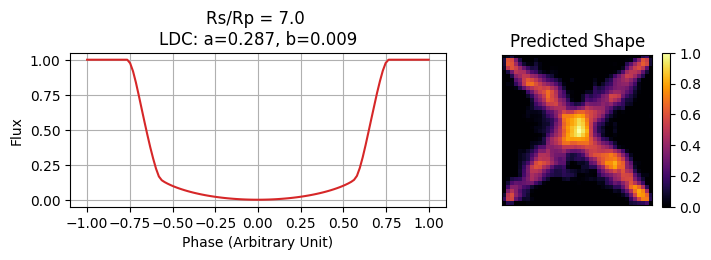

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8,2),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title(f'Rs/Rp = {round(size[k],0)} \nLDC: a={round(LDCs[k][0], 3)}, b={round(LDCs[k][1],3)}')
axes[0].plot(ph, processed_test_lc[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()


In [26]:
# shape_dir = '/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/test_shape_2/test_shape_2.npy'
shape_dir = '/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/test_lc_shape_1_multisize_multiLDC_3/test_shape_1.npy'
# April 9 and April 25 test dataset used thesame test_shape_1
test_shape = np.load(shape_dir)

# Normalize the image, convert to opacity map
## Test Set
test_shape = test_shape/np.amax(test_shape)
test_shape_where_0 = np.where(test_shape == 0)
test_shape_where_1 = np.where(test_shape == 1)
test_shape[test_shape_where_0] = 1  # 1 represent the shape (1 opacity)
test_shape[test_shape_where_1] = 0  # 0 represent background (0 opacity)

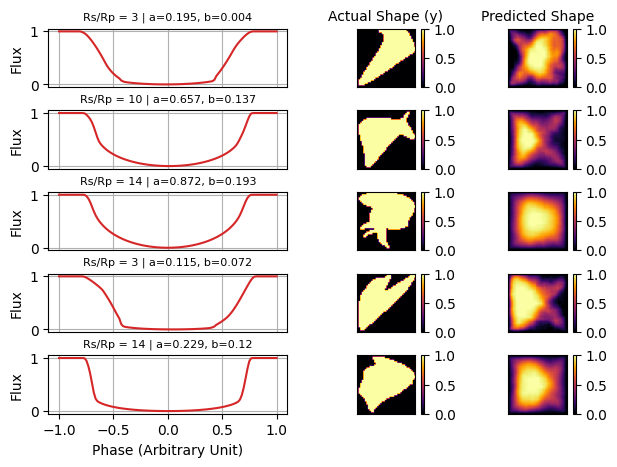

In [27]:
# Plot random set of 5 light curves and predictions
num = 5
fig,ax=plt.subplots(num,3, figsize=(7,5), gridspec_kw={ 'width_ratios': [2,1,1],
        'wspace': 0.2,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 200

ax[0][1].set_title('Actual Shape (y)',size=10)
ax[0][2].set_title(r'Predicted Shape',size=10)
ax[num-1][0].set_xlabel('Phase (Arbitrary Unit)',size=10)
ph = np.linspace(-1.0,1.0,len(processed_test_lc[0]))
# advance = 60
for i in range(num):
    k =  random.randint(0, len(processed_test_lc)-1) # 249 - i #
    # k = i
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    if(i<num-1): ax[i][0].tick_params(labelbottom = False, bottom = False)
    img = ax[i][1].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)
    ax[i][0].set_title(f'Rs/Rp = {round(size[k])} | a={round(LDCs[k][0], 3)}, b={round(LDCs[k][1],3)}',size=8)
    ax[i][0].set_ylabel('Flux', size=10)
    # ax[i][0].set_ylim(-0.5,1.5)
    ax[i][0].plot(ph, processed_test_lc[k],color = 'tab:red',linewidth=1.5)
    ax[i][0].grid('on')
    img = ax[i][2].imshow(test_predict_shape[k],cmap='inferno')
    plt.colorbar(img)

plt.show()

**Calculate MSE**

In [28]:
# All the codes for calculating MSE for noiseless case

def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

def fold_predicted_image_array(org_image_array):
    threshold = 0.3
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=threshold] = 1
    folded_org_image_array[folded_org_image_array<threshold] = 0
    return(folded_org_image_array)

def calc_MSE(ary1,ary2):
    MSE = 0
    if ary1.shape == ary2.shape:
        for i in np.arange(len(ary1)):
            MSE = MSE + np.mean((ary1[i] - ary2[i])**2)
        MSE = MSE/len(ary1)
        # print("MSE = ",MSE)
        return(MSE)
    else:
        print("Given array shape not same")

# MSE without folding
mse = calc_MSE(test_shape, test_predict_shape)
print("Noiseless MSE-> ",mse)

# MSE after folding
# Fold the shapes
folded_test_shape_array = fold_original_image_array(test_shape)
folded_predicted_shape_array_no_noise = fold_predicted_image_array(test_predict_shape)

mse = calc_MSE(folded_test_shape_array, folded_predicted_shape_array_no_noise)
print("Noiseless MSE (Folded)-> ",mse)

Noiseless MSE->  0.1376993465305761
Noiseless MSE (Folded)->  0.1508421052631579


In [29]:
# Add Noise and calculate MSE
# Function to Add noise to Test light curve
def add_noise(test_lc_scaled_append,SNR):
    std_dev = 1/SNR
    test_lc_scaled_append_noise = np.ones(test_lc_scaled_append.shape)
    rng = np.random.default_rng()

    for i in np.arange(len(test_lc_scaled_append)):
        noise_temp = np.random.normal(loc=0.0, scale=std_dev, size=len(test_lc_scaled_append[i]))
        rng.shuffle(noise_temp)
        test_lc_scaled_append_noise[i] = test_lc_scaled_append[i] + noise_temp
    return test_lc_scaled_append_noise

# Add noise to the light curve
processed_test_lc_SNR500 = add_noise(processed_test_lc,SNR=500)
processed_test_lc_SNR200 = add_noise(processed_test_lc,SNR=200)
processed_test_lc_SNR150 = add_noise(processed_test_lc,SNR=150)
processed_test_lc_SNR100 = add_noise(processed_test_lc,SNR=100)
processed_test_lc_SNR75 = add_noise(processed_test_lc,SNR=75)
processed_test_lc_SNR50 = add_noise(processed_test_lc,SNR=50)

def normalize_shape(test_predict_shape):
    test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
    for i in np.arange(len(test_predict_shape)):
        test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
    print("Normalized the predicted shape")
    return test_predict_shape_normalized

In [30]:
results = model_load.evaluate(processed_test_lc_SNR500, test_shape, batch_size=125,verbose=0)
print("SNR = 500. Loss ->",results)
test_predict_shape_SNR500 = model_load.predict(processed_test_lc_SNR500)
test_predict_shape_SNR500 = normalize_shape(test_predict_shape_SNR500)

results = model_load.evaluate(processed_test_lc_SNR200, test_shape, batch_size=125,verbose=0)
print("SNR = 200. Loss ->",results)
test_predict_shape_SNR200 = model_load.predict(processed_test_lc_SNR200)
test_predict_shape_SNR200 = normalize_shape(test_predict_shape_SNR200)

results = model_load.evaluate(processed_test_lc_SNR150, test_shape, batch_size=125,verbose=0)
print("SNR = 150. Loss ->",results)
test_predict_shape_SNR150 = model_load.predict(processed_test_lc_SNR150)
test_predict_shape_SNR150 = normalize_shape(test_predict_shape_SNR150)

results = model_load.evaluate(processed_test_lc_SNR100, test_shape, batch_size=125,verbose=0)
print("SNR = 100. Loss ->",results)
test_predict_shape_SNR100 = model_load.predict(processed_test_lc_SNR100)
test_predict_shape_SNR100 = normalize_shape(test_predict_shape_SNR100)

results = model_load.evaluate(processed_test_lc_SNR75, test_shape, batch_size=125,verbose=0)
print("SNR = 75. Loss ->",results)
test_predict_shape_SNR75 = model_load.predict(processed_test_lc_SNR75)
test_predict_shape_SNR75 = normalize_shape(test_predict_shape_SNR75)

results = model_load.evaluate(processed_test_lc_SNR50, test_shape, batch_size=125,verbose=0)
print("SNR = 50. Loss ->",results)
test_predict_shape_SNR50 = model_load.predict(processed_test_lc_SNR50)
test_predict_shape_SNR50 = normalize_shape(test_predict_shape_SNR50)

SNR = 500. Loss -> 0.13887841999530792
8/8 [==============================] - 0s 47ms/step
Normalized the predicted shape
SNR = 200. Loss -> 0.14389581978321075
8/8 [==============================] - 0s 48ms/step
Normalized the predicted shape
SNR = 150. Loss -> 0.14549270272254944
8/8 [==============================] - 0s 49ms/step
Normalized the predicted shape
SNR = 100. Loss -> 0.149187371134758
8/8 [==============================] - 0s 49ms/step
Normalized the predicted shape
SNR = 75. Loss -> 0.15149585902690887
8/8 [==============================] - 0s 45ms/step
Normalized the predicted shape
SNR = 50. Loss -> 0.1551123410463333
8/8 [==============================] - 0s 45ms/step
Normalized the predicted shape


k =  0
k =  1
k =  2
k =  3
k =  4


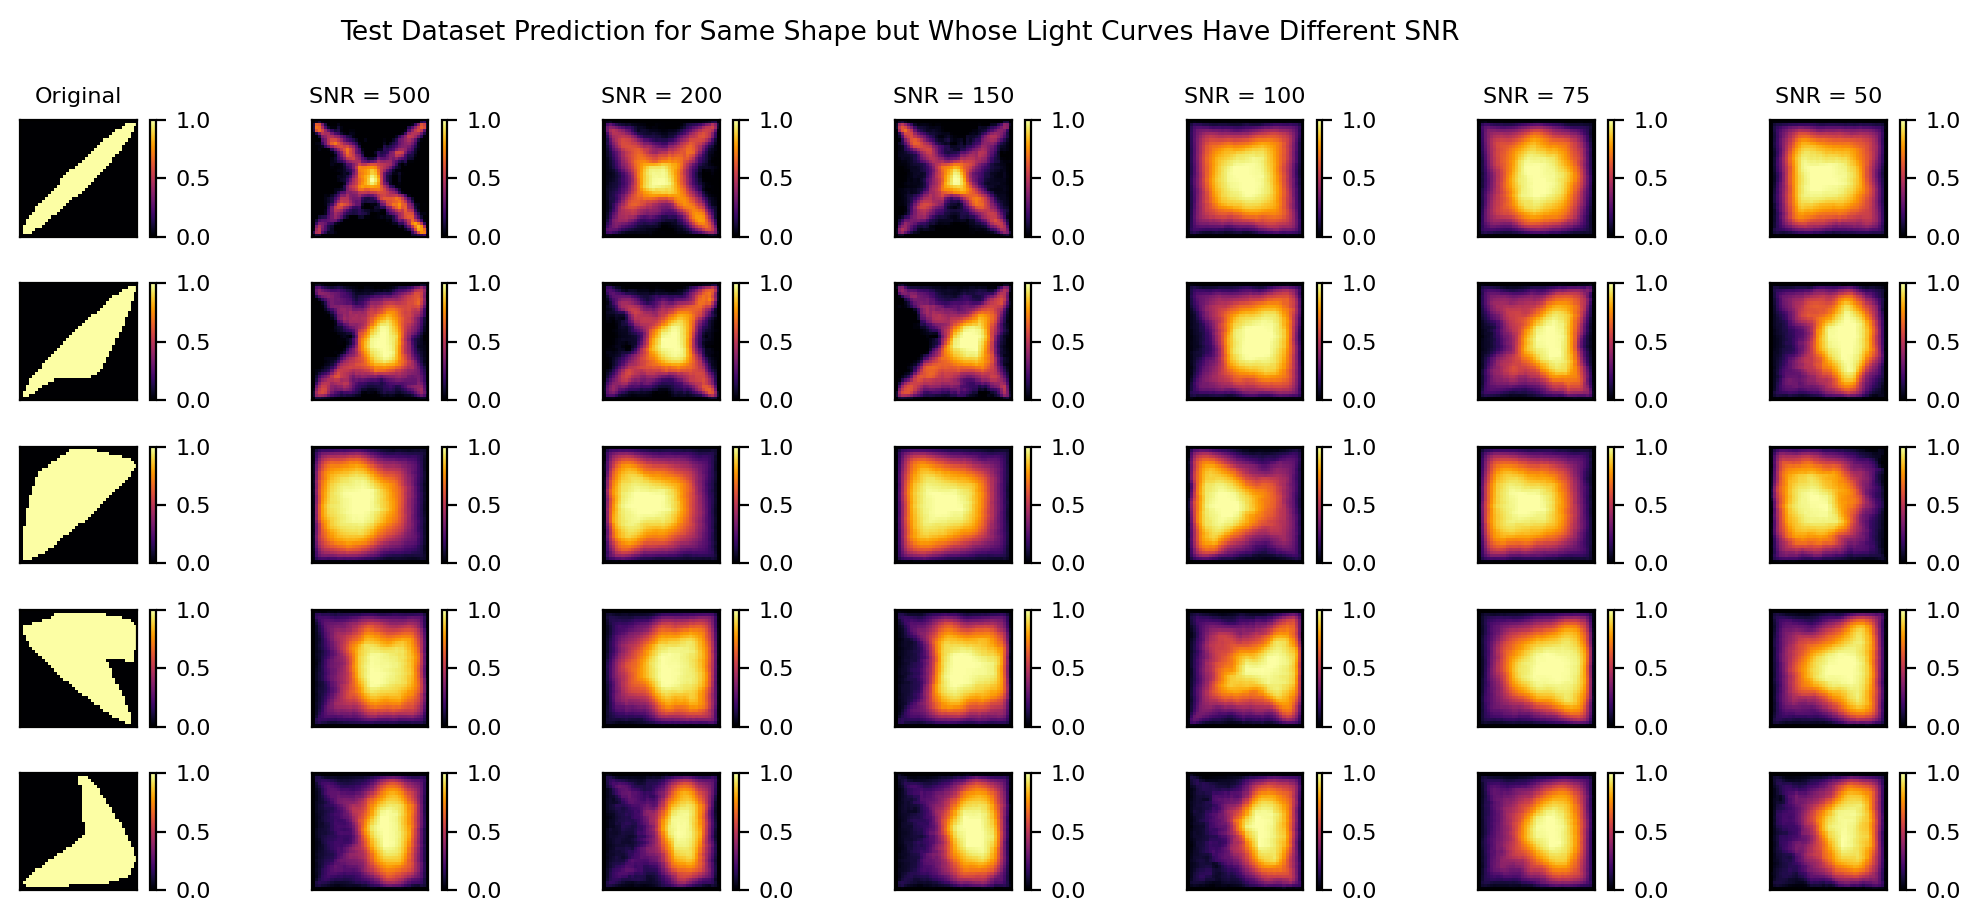

In [31]:
# Plot predicted shapes
num = 5
fig,ax=plt.subplots(num,7, figsize=(13,5), gridspec_kw={ 'width_ratios': [1,1,1,1,1,1,1],
        'wspace': 0.1,'hspace': 0.4})
plt.rcParams['figure.dpi'] = 1000
plt.rcParams.update({'font.size': 8})

ax[0][0].set_title('Original',size=8)
ax[0][1].set_title('SNR = 500',size=8)
ax[0][2].set_title('SNR = 200',size=8)
ax[0][3].set_title('SNR = 150',size=8)
ax[0][4].set_title('SNR = 100',size=8)
ax[0][5].set_title('SNR = 75',size=8)
ax[0][6].set_title('SNR = 50',size=8)

temp = np.linspace(0, len(test_lc_scaled_append)-1,len(test_lc_scaled_append))
index_test_array = np.random.choice(temp, size=(num,), replace=False)

for i in range(num):
    k =  i # random.randint(0, len(test_shape)-1) # i i # int(index_test_array[i]) #
    print("k = ",k)
    ax[i][0].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][2].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][3].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][4].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][5].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    ax[i][6].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)

    img = ax[i][0].imshow(test_shape[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][1].imshow(test_predict_shape_SNR500[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][2].imshow(test_predict_shape_SNR200[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][3].imshow(test_predict_shape_SNR150[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][4].imshow(test_predict_shape_SNR100[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][5].imshow(test_predict_shape_SNR75[k],cmap='inferno')
    plt.colorbar(img)

    img = ax[i][6].imshow(test_predict_shape_SNR50[k],cmap='inferno')
    plt.colorbar(img)

plt.suptitle('Test Dataset Prediction for Same Shape but Whose Light Curves Have Different SNR')
plt.show()

In [32]:
# All the required codes for folding and calculating MSE

def fold_original_image_array(org_image_array):
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
    folded_org_image_array[folded_org_image_array>0] = 1
    return(folded_org_image_array)

def fold_predicted_image_array(org_image_array):
    threshold = 0.3
    # Return an array containing folding each 2d shape
    folded_org_image_array = np.zeros((int(org_image_array.shape[0]),int(org_image_array.shape[1]/2),int(org_image_array.shape[2]) ))
    for i in np.arange(len(org_image_array)):
        image_top = org_image_array[i,0:int(org_image_array.shape[1]/2),:]
        image_bottom = org_image_array[i,int(org_image_array.shape[1]/2):,:]
        image_bottom_flip = np.flipud(image_bottom)
        folded_org_image_array[i] = image_bottom_flip+image_top
        folded_org_image_array[i] = (folded_org_image_array[i] - np.amin(folded_org_image_array[i]))/(np.amax(folded_org_image_array[i]) - np.amin(folded_org_image_array[i]))
    folded_org_image_array[folded_org_image_array>=threshold] = 1
    folded_org_image_array[folded_org_image_array<threshold] = 0
    return(folded_org_image_array)

def calc_MSE(ary1,ary2):
    MSE = 0
    if ary1.shape == ary2.shape:
        for i in np.arange(len(ary1)):
            MSE = MSE + np.mean((ary1[i] - ary2[i])**2)
        MSE = MSE/len(ary1)
        # print("MSE = ",MSE)
        return(MSE)
    else:
        print("Given array shape not same")

# Fold the original shapes
folded_test_shape_array = fold_original_image_array(test_shape)

# Fold the predicted shapes for different SNR
folded_predicted_shape_array_SNR500 = fold_predicted_image_array(test_predict_shape_SNR500)
folded_predicted_shape_array_SNR200 = fold_predicted_image_array(test_predict_shape_SNR200)
folded_predicted_shape_array_SNR150 = fold_predicted_image_array(test_predict_shape_SNR150)
folded_predicted_shape_array_SNR100 = fold_predicted_image_array(test_predict_shape_SNR100)
folded_predicted_shape_array_SNR75 = fold_predicted_image_array(test_predict_shape_SNR75)
folded_predicted_shape_array_SNR50 = fold_predicted_image_array(test_predict_shape_SNR50)


print("MSE without folding")
mse = calc_MSE(test_shape,test_predict_shape_SNR500)
print("SNR = 500 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR200)
print("SNR = 200 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR150)
print("SNR = 150 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR100)
print("SNR = 100 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR75)
print("SNR = 75 -> ",mse)
mse = calc_MSE(test_shape,test_predict_shape_SNR50)
print("SNR = 50 -> ",mse)


print("MSE after folding the shape")
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR500)
print("SNR = 500 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR200)
print("SNR = 200 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR150)
print("SNR = 150 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR100)
print("SNR = 100 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR75)
print("SNR = 75 -> ",mse)
mse = calc_MSE(folded_test_shape_array,folded_predicted_shape_array_SNR50)
print("SNR = 50 -> ",mse)


MSE without folding
SNR = 500 ->  0.13878908126416972
SNR = 200 ->  0.1438485239324126
SNR = 150 ->  0.14545947126785835
SNR = 100 ->  0.14927460995275088
SNR = 75 ->  0.15154949121430886
SNR = 50 ->  0.15517993536548158
MSE after folding the shape
SNR = 500 ->  0.15452631578947365
SNR = 200 ->  0.16488642659279773
SNR = 150 ->  0.1677396121883655
SNR = 100 ->  0.17383379501385032
SNR = 75 ->  0.17578947368421063
SNR = 50 ->  0.18285318559556782


In [ ]:
# Plot for SNR vs MSE
# # Given data
# snr = [500, 200, 150, 100, 75, 50]
# mse = [0.1615, 0.1706, 0.1722, 0.1732, 0.1788, 0.1854]

# # Plotting the data
# plt.plot(snr, mse, marker='o', linestyle='-', color="black")
# plt.title('Variation of Folded MSE with SNR')
# plt.xlabel('SNR')
# plt.ylabel('Folded MSE')
# plt.xlim(0, 600)
# plt.ylim(0.160, 0.190)

# plt.grid(True)
# plt.show()

# Load a single light curve to predict (old)

In [ ]:
# 1. Load Lightcurve Dataset
# lc_dir =  '/scratch/abraham/Documents/mega_git/mega/data/test/npy/lc/lc_shape_1_multisize_multiLDC.npy'
# lc_dir = '/content/drive/MyDrive/5_AstroFYP_data/april_25_model_training/BATMAN_LIGHTCURVE/'
# lc_name = 'BATMAN_startoplanet3_a0.8_b0.18.npy'
# lc_name = 'BATMAN_startoplanet18_a0.3_b0.12.npy'

test_lc = np.load(lc_dir+lc_name)
print("test_lc.shape = ", test_lc.shape)

test_lc = np.reshape(test_lc, newshape=(1,120))
print("test_lc.shape = ", test_lc.shape)

# Don't run if data is already normalized
# Normalize the lightcurves
## - Test Set
test_lc_scaled = np.zeros(test_lc.shape)
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled[i] = (test_lc[i] - np.amin(test_lc[i]))/(np.amax(test_lc[i]) - np.amin(test_lc[i]))

test_lc.shape =  (120,)
test_lc.shape =  (1, 120)


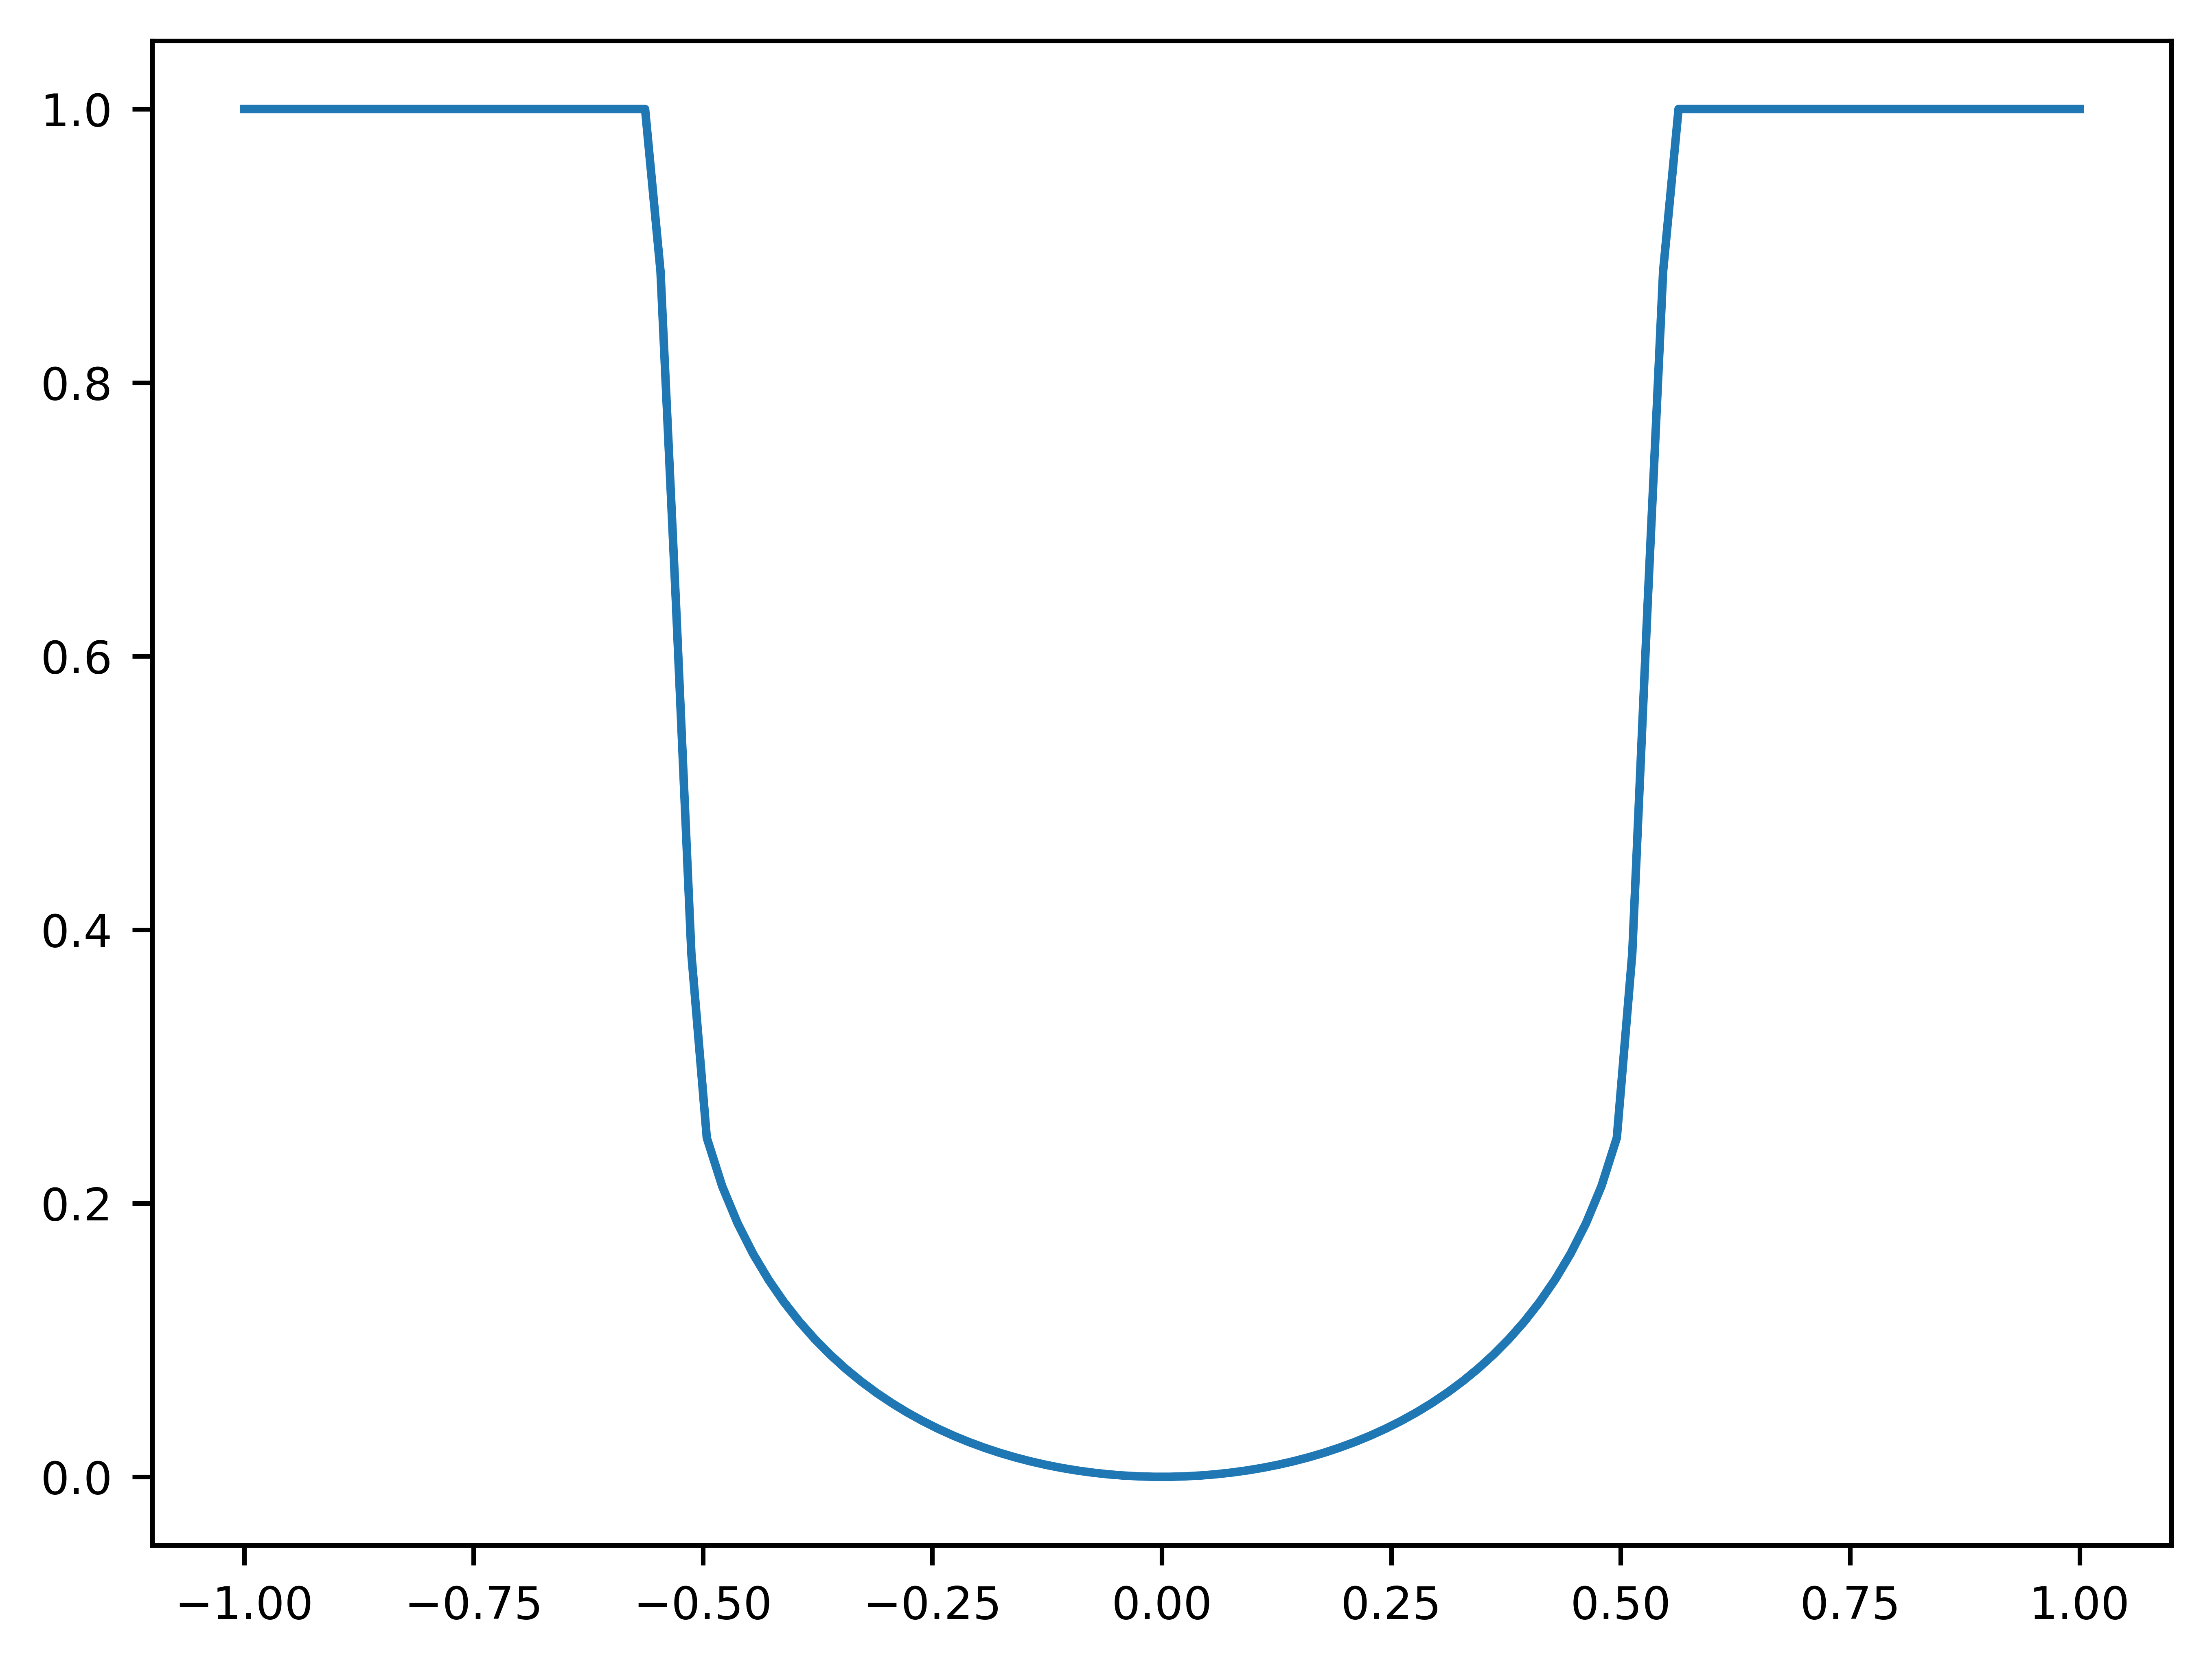

In [ ]:
plt.plot(np.linspace(-1,1,len(test_lc_scaled[0])), test_lc_scaled[0])
plt.show()

In [ ]:
# Append with ones (if required only.
# eg APPENING not required for BATMAN lightcurve since we already append BATMAN
# while saving it as csv file and npy file)
## - Test Set
test_lc_scaled_append = np.ones((test_lc.shape[0],150))
for i in np.arange(len(test_lc_scaled)):
    test_lc_scaled_append[i,15:135] = test_lc_scaled[i]
print("Extended the light curves")

# del test_lc
# del test_lc_scaled

Extended the light curves


In [ ]:
# 5. Horizontal scaling
def scale_horizontally(input_lc_dataset):
    # lc_np_array_offset_mask used to select the flat part by certain percentage
    input_lc_dataset_mask = np.copy(input_lc_dataset)

    for iteration in np.arange(len(input_lc_dataset)):
        # 0.988 is working good | lower it and see changes # 0.96 - 0.97 -better # 0.95 -worse
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]>=0.98)] = 1.0
        input_lc_dataset_mask[iteration][(input_lc_dataset[iteration]<0.98)] = 0.0

    print("Length of one LC = ", len(input_lc_dataset_mask[0]))

    count_zeros_array = np.zeros((len(input_lc_dataset_mask),))
    for iteration in np.arange(len(input_lc_dataset_mask)):
        # Calculate the number of occurrences of '0'
        count_zeros = np.count_nonzero(input_lc_dataset_mask[iteration] == 0)
        count_zeros_array[iteration] = count_zeros

    # Interpolate the light curve
    input_lc_dataset_interpol = np.zeros((len(input_lc_dataset), 120))
    len_selected_portion = np.zeros(len(input_lc_dataset))
    print("input_lc_dataset_interpol.shape =", input_lc_dataset_interpol.shape)

    center_index = int(len(input_lc_dataset[0])/2)
    print("center_index =", center_index)

    for iteration in np.arange(len(input_lc_dataset_interpol)):

        left_index = int(center_index - int(count_zeros_array[iteration]/2) - int(count_zeros_array[iteration]/6))
        right_index = int(center_index + int(count_zeros_array[iteration]/2) + int(count_zeros_array[iteration]/6))
        selected_portion = input_lc_dataset[iteration][left_index:right_index]
        print("left_index =", left_index)
        print("right_index =", right_index)
        print("Length =", right_index-left_index+1)

        # Calculate the length of the selected region
        len_selected_portion[iteration] = len(selected_portion)

        # Interpolate the selected portion
        # Original data
        original_x = np.linspace(-1, 1, num=len(selected_portion))
        original_y = selected_portion

        # Create a quadratic interpolation function
        f = interp1d(original_x, original_y, kind='linear')

        # Define the range of x-values for the interpolation with 120 elements
        x_interpolation = np.linspace(-1, 1, num=120)

        # Perform the interpolation
        y_interpolated = f(x_interpolation)

        # # Replacing end elements with 1

        # y_interpolated[0:9] = np.ones(len(y_interpolated[0:9]))
        # # print(f"len(y_interpolated[0:9])) = {len(y_interpolated[0:9])}")

        # y_interpolated[111:120] = np.ones(len(y_interpolated[111:120]))
        # # print(f"len(y_interpolated[111:120])) = {len(y_interpolated[111:120])}")

        input_lc_dataset_interpol[iteration] = y_interpolated

    return input_lc_dataset_interpol

test_lc_horiz_scaled = scale_horizontally(test_lc_scaled_append)
# del test_lc_scaled_append

processed_test_lc = test_lc_horiz_scaled
# del test_lc_horiz_scaled


Length of one LC =  150
input_lc_dataset_interpol.shape = (1, 120)
center_index = 75
left_index = 31
right_index = 119
Length = 89


In [ ]:
# Test on the ML model - Test Dataset - Original Simulated light curve
# (i.e. without sampling and interpolation)
# Test dataset - Prediciton
# processed_test_lc = np.zeros(shape=(1,120))
test_predict_shape = model_load.predict(processed_test_lc) # model_load.predict(test_lc_scaled) #
test_predict_shape_normalized = np.zeros(test_predict_shape.shape)
for i in np.arange(len(test_predict_shape)):
    test_predict_shape_normalized[i] = (test_predict_shape[i] - np.amin(test_predict_shape[i]))/(np.amax(test_predict_shape[i]) - np.amin(test_predict_shape[i]))
print("Normalized the predicted shape")
test_predict_shape = test_predict_shape_normalized
del test_predict_shape_normalized

1/1 [==============================] - 0s 39ms/step
Normalized the predicted shape


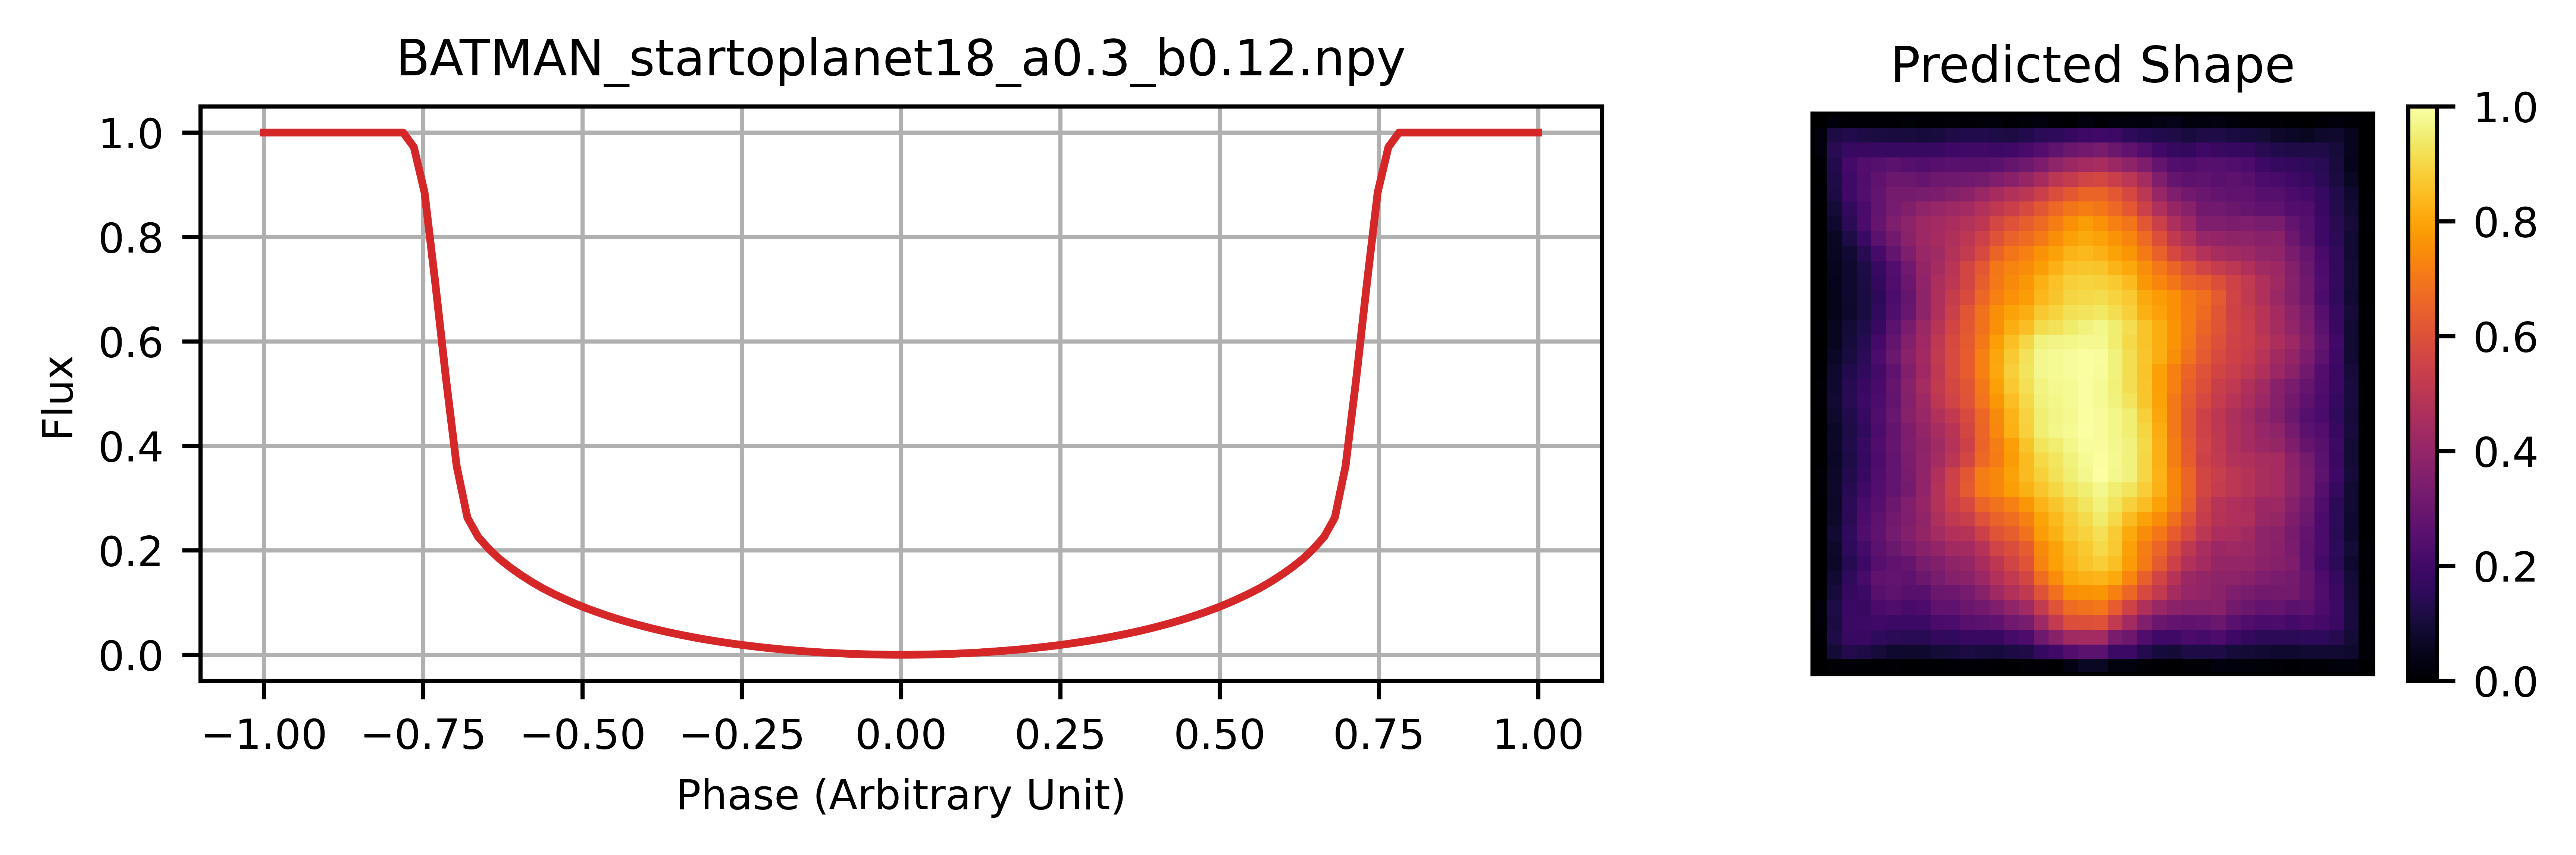

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8,2),gridspec_kw={'width_ratios': [2,1]})  # 1 row, 2 columns
ph = np.linspace(-1,1,len(processed_test_lc[0]))

# Plot on each subplot
k = int(0) # Index
axes[0].set_title(lc_name)
axes[0].plot(ph, processed_test_lc[k], color='tab:red')
axes[0].grid('on')
axes[0].set_ylabel('Flux')
axes[0].set_xlabel('Phase (Arbitrary Unit)')


axes[1].set_title('Predicted Shape')
axes[1].tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
img = axes[1].imshow(test_predict_shape[k],cmap='inferno')
plt.colorbar(img)

plt.show()
